### Machine Learning for Asset Managers

#Chapter 2: Denoising and Detoning

Esse segundo capítulo apresenta uma metodologia parar tratar o ruído e reter o sinal de matrizes de covariância. Esse procedimento é muito útil para obter melhores carteiras com o processo de Markovitz. Para isso, usamos da conclusão do  teorema de Marchenko-Pastur, que diz que uma matriz (NxT) com entradas iid cujo processo gerador dos dados possui média zero e variância definida terá, quando N, T tenderem ao infinito, autovalores que seguirão um dada distribuiço — Marchenko-Pastur. 

A ideia de usar desse teorema é que se o conteúdo da matriz for realmente aleatório, a distribuição dos autovalores seguirá a fdp de Marcenko-Pastur. Todos os autovalores dentro do range definido pela função são compatíveis com um comportamento estocástico. Por outro lado, o que está fora possui algum tipo de estrutura e é o que o livro chama de sinal. 


*Tentei juntar a explicação de vários lugares. Os códgios não são necessariamente meus.

*Outras referências: 
https://medium.com/swlh/an-empirical-view-of-marchenko-pastur-theorem-1f564af5603d
https://faculty.baruch.cuny.edu/jgatheral/RandomMatrixCovariance2008.pdf
https://srome.github.io/Eigenvesting-III-Random-Matrix-Filtering-In-Finance/

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

In [2]:
def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
        var (float): Variance
        q (float): T/N where T is the number of rows and N the number of columns
        pts (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf

A figura abaixo apresenta o que deveria ser a distribuição dos autovalores de uma matriz estocástica.

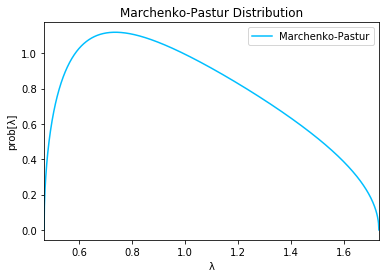

In [3]:
m = mpPDF(1, 1000/100, 1000)

ax = m.plot(title="Marchenko-Pastur Distribution", label="Marchenko-Pastur", color="deepskyblue")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")

In [4]:
def getPCA(matrix):
    """
    Gets the Eigenvalues and Eigenvector values from a Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation matrix
    Returns:
         (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation matrix
            np.ndarray: Eigenvectors of correlation matrix
    """
    # Get eVal,eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [5]:
def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs x is the array of values
        on which the fit KDE will be evaluated. It is the empirical PDF
    Args:
        obs (np.ndarray): observations to fit. Commonly is the diagonal of Eigenvalues
        bWidth (float): The bandwidth of the kernel. Default is .25
        kernel (str): The kernel to use. Valid kernels are [‘gaussian’|’tophat’|
            ’epanechnikov’|’exponential’|’linear’|’cosine’] Default is ‘gaussian’.
        x (np.ndarray): x is the array of values on which the fit KDE will be evaluated
    Returns:
        pd.Series: Empirical PDF
    """
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

Acima temos as funções que usaremos. A primeira é a função de distribuição de probabilidades de Marchenko-Pastur, a segunda calcula os autovalores e autovetores de uma matriz e por fim a terceira ajusta uma função de densidade Kernel a matriz. O próximo passo é gerar uma matriz aleatória e testar o teorema.  

In [6]:
#Gerando uma matriz aleatoria 
x = np.random.normal(size=(10000,1000))

In [7]:
# Getting eigenvalues and eigenvectors
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))

In [11]:
# Marchenko-Pastur pdf
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)

In [12]:
# Empirical pdf
pdf1= fitKDE(np.diag(eVal0), bWidth=0.01)

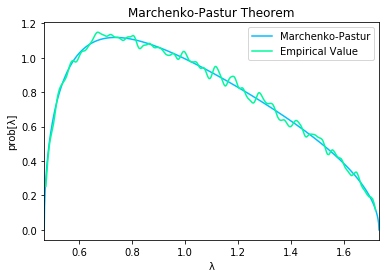

In [13]:
# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")

In [14]:
def getRndCov(nCols, nFacts):
    """
    Generates a Random Covariance Matrix
    Args:
        nCols (int): number of columns of random normal. This will be the dimensions of
            the output
        nFacts (int): number of rows of random normal
    Returns:
        np.ndarray: random covariance matrix
    """
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols))  # full rank cov
    return cov

In [15]:
def cov2corr(cov):
    """
    Derive the correlation matrix from a covariance matrix
    Args:
        cov (np.ndarray): covariance matrix
    Returns:
        np.ndarray: correlation matrix
    """
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr

In [16]:
def errPDFs(var, eVal, q, bWidth, pts=1000):
    """
    Fit error of Empirical PDF (uses Marchenko-Pastur PDF)
    Args:
        var (float): Variance
        eVal (np.ndarray): Eigenvalues to fit.
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
        pts (int): Number of points used to construct the PDF
    Returns:
        float: sum squared error
    """
    # Fit error
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0) ** 2)
    return sse

In [17]:
def findMaxEval(eVal, q, bWidth):
    """
    Find max random eVal by fitting Marchenko’s dist (i.e) everything else larger than
        this, is a signal eigenvalue
    Args:
        eVal (np.ndarray): Eigenvalues to fit on errPDFs
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
    Returns:
         (tuple): tuple containing:
            float: Maximum random eigenvalue
            float: Variance attributed to noise (1-result) is one way to measure
                signal-to-noise
    """

    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth),
                   bounds=((1E-5, 1 - 1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1. / q) ** .5) ** 2
    return eMax, var

In [63]:
alpha, nCols, nFact, q = .995, 1000, 100, 10
# Random Matrix
rand_matrix = np.random.normal(size=(nCols * q, nCols))
# Covariance Matrix
cov = np.cov(rand_matrix, rowvar=0)
# Adding signal to Covariance Matrix
cov = alpha * cov + (1 - alpha) * getRndCov(nCols, nFact) # noise + signal
# Converting Covariancce to Correlation
corr0 = cov2corr(cov)
# Getting Eigenvalues and Eigenvectors
eigenv_with_signal, eVec0 = getPCA(corr0)

In [64]:
# Getting Max Eigenvalues and calculating variance attributed to noise
eMax0, var0 = findMaxEval(np.diag(eigenv_with_signal), q, bWidth=0.01)
nFacts0 = eigenv_with_signal.shape[0] - np.diag(eigenv_with_signal)[::-1].searchsorted(eMax0)

In [65]:
# Getting PDFs and plotting it
pdf0 = mpPDF(var0, q=10, pts=1000)
pdf1 = fitKDE(np.diag(eigenv_with_signal), bWidth=0.01)  # Empirical PDF

(0, 2)

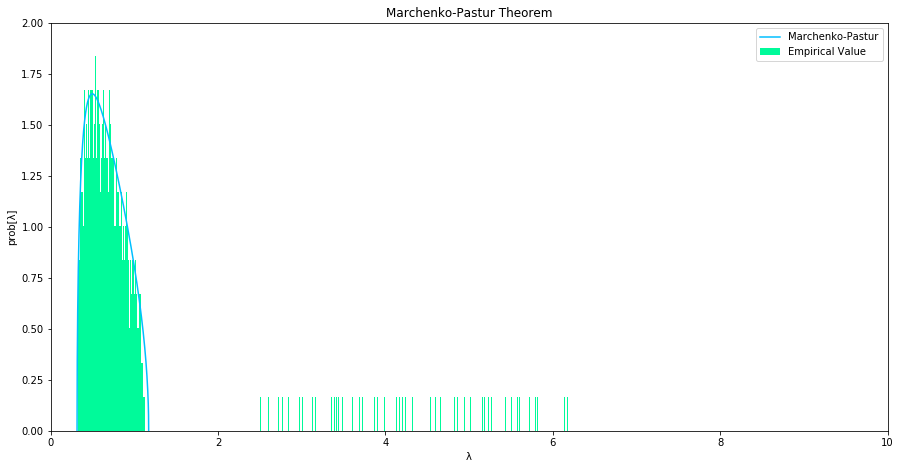

In [68]:
# Plotting PDFs
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue", figsize=(15,7.5))
ax.hist(pd.Series(np.diag(eigenv_with_signal)), density="norm", bins=1000, label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")
# Set the limit for each axis
plt.xlim(0, 10)
plt.ylim(0,2)

Tudo o que está a direita pode ser associado como sinal. 